Here we will provide some simple explaining the pros and cons of Spearman / Pearson correlation 
compared to multimodal autoencoders

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from benchmark_mae.evaluate import edge_roc_curve
from benchmark_mae.sim import cystic_fibrosis_simulation
from minstrel.util import rank_hits
from minstrel.multimodal import Autoencoder

from itertools import product
from skbio.stats.composition import clr, centralize
from skbio.stats.composition import clr_inv as softmax
from scipy.sparse import coo_matrix
from scipy.stats import rankdata
import matplotlib.colors as colors
import glob
import yaml

from scipy.stats import spearmanr, pearsonr
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
df = cystic_fibrosis_simulation(data_dir="../benchmark_mae/data")

In [3]:
df[['P','I','SA','SG','F']] = df[['P','I','SA','SG','F']] * 1e6
df[['theta_f', 'theta_p']] = df[['theta_f', 'theta_p']] * 1e3
df['microbial_total'] = df[['theta_f', 'theta_p']].sum(axis=1)
df['metabolite_total'] = df[['F', 'P', 'I', 'SA', 'SG']].sum(axis=1)
df['metabolite_total'] = df[['F', 'P', 'I', 'SA', 'SG']].sum(axis=1)
df['evil_total'] = df.metabolite_total * (df.time+1)

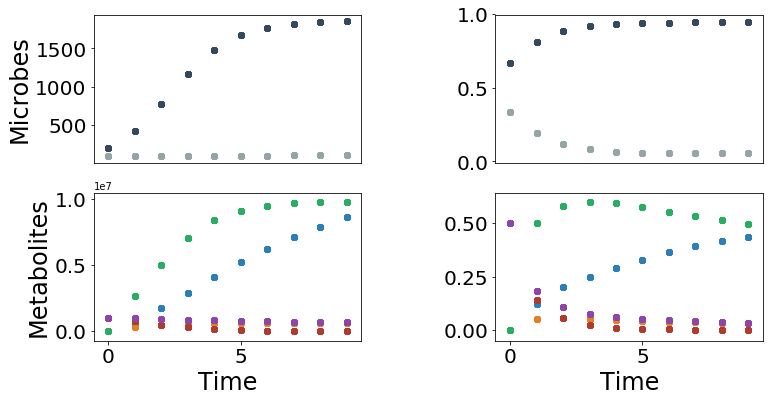

In [34]:
labelsize = 20
fontsize = 24
microbe_names = ['theta_f', 'theta_p']
metabolite_names = ['F', 'I', 'P', 'SA', 'SG']

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
metadata = df.loc[np.logical_and(df['y']==20, df['time'] < 10)]
mode = 'time'


type_colors = {'SA': '#B03A2E',
               'F': '#2980B9',
               'P': '#27AE60',
               'SG': '#8E44AD',
               'I': '#E67E22'
              }

microbe_colors = {
    'theta_f': '#95A5A6',
    'theta_p': '#34495E'
}
for m in microbe_names:
    axes[0][0].scatter(
        metadata[mode], metadata[m], label=m,
        color=microbe_colors[m]        
    )
#axes[0][0].legend(prop={'size': labelsize}, loc=4)
axes[0][0].set_xticks([])
axes[0][0].xaxis.set_tick_params(labelsize=labelsize)
axes[0][0].yaxis.set_tick_params(labelsize=labelsize)
axes[0][0].set_ylabel('Microbes', fontsize=fontsize)

microbe_legend = {}
for m in microbe_names:
    microbe_legend[m] = axes[0][1].scatter(
        metadata[mode], metadata[m] / metadata.microbial_total, label=m,
        color=microbe_colors[m]
    )
axes[0][1].set_xticks([])
axes[0][1].xaxis.set_tick_params(labelsize=labelsize)
axes[0][1].yaxis.set_tick_params(labelsize=labelsize)


for k in metabolite_names:
    axes[1][0].scatter(
        metadata[mode], metadata[k], label=k,
        color=type_colors[k])        
#axes[1][0].legend(prop={'size': labelsize}, loc=4)

axes[1][0].xaxis.set_tick_params(labelsize=labelsize)
axes[1][0].yaxis.set_tick_params(labelsize=labelsize)
axes[1][0].set_xlabel('Time', fontsize=fontsize)
axes[1][0].set_ylabel('Metabolites', fontsize=fontsize)

metabolite_legend = {}
for k in metabolite_names:
    metabolite_legend[k] = axes[1][1].scatter(
        metadata[mode], metadata[k] / metadata.metabolite_total, label=k,
        color=type_colors[k])
axes[1][1].xaxis.set_tick_params(labelsize=labelsize)
axes[1][1].yaxis.set_tick_params(labelsize=labelsize)
axes[1][1].set_xlabel('Time', fontsize=fontsize)


fig.subplots_adjust(wspace=0.5)

plt.savefig('../results/simple_sim.png')

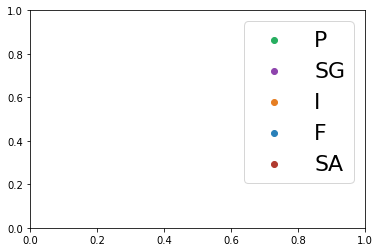

In [37]:
plt.legend(list(metabolite_legend.values()), metabolite_legend.keys(), fontsize=22)
plt.savefig('../results/metabolite_legend.png')

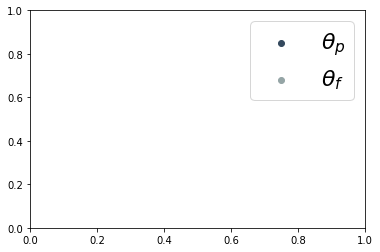

In [38]:
plt.legend(list(microbe_legend.values()), [r'$\theta_p$', r'$\theta_f$'], fontsize=22)
plt.savefig('../results/microbe_legend.png')

In [5]:
abs_microbes = metadata[microbe_names]
rel_microbes = metadata.apply(lambda x: x[microbe_names] / x['microbial_total'], axis=1)

abs_metabolites = metadata[metabolite_names]
rel_metabolites = metadata.apply(lambda x: x[metabolite_names] / x['metabolite_total'], axis=1)

In [6]:
abs_microbe_total = (abs_microbes.sum(axis=1) * 100).astype(np.int64)
rel_microbe_total = 100

abs_metabolite_total = abs_metabolites.sum(axis=1)*10e5
rel_metabolite_total = rel_metabolites.sum(axis=1)*10e5

ms_sigma = .1

In [7]:
abs_microbes = abs_microbes.apply(
    lambda x: np.random.multinomial(n=abs_microbe_total[x.name], pvals=x/x.sum()), axis=1
)

rel_microbes = rel_microbes.apply(
    lambda x: np.random.multinomial(n=rel_microbe_total, pvals=x/x.sum()), axis=1
)

abs_metabolites = abs_metabolites.apply(
    lambda x: np.random.lognormal(np.log(abs_metabolite_total[x.name] * x/x.sum()), ms_sigma), axis=1
)

rel_metabolites = rel_metabolites.apply(
    lambda x: np.random.lognormal(
        np.log(rel_metabolite_total[x.name] * x/x.sum()), ms_sigma), axis=1
)

/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/mortonjt/miniconda3/envs/bayesian-regression/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


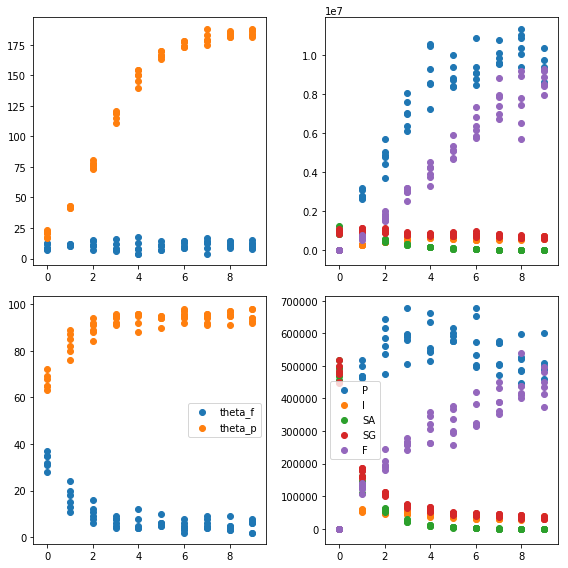

In [8]:
microbe_names = ['theta_f', 'theta_p']
metabolite_names = ['P', 'I', 'SA', 'SG', 'F']

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
metadata = df.loc[np.logical_and(df['y']==20, df['time'] < 10)]
mode = 'time'


for m in microbe_names:
    axes[0][0].scatter(
        metadata.loc[abs_microbes.index, mode], abs_microbes[m], label=m)


for m in microbe_names:
    axes[1][0].scatter(
        metadata.loc[rel_microbes.index, mode], rel_microbes[m], label=m)
    
axes[1][0].legend()

for m in metabolite_names:
    axes[0][1].scatter(
        metadata.loc[abs_metabolites.index, mode], abs_metabolites[m], label=m)


for m in metabolite_names:
    axes[1][1].scatter(
        metadata.loc[rel_metabolites.index, mode], rel_metabolites[m], label=m)
axes[1][1].legend()

plt.tight_layout()

Run maestro on absolute data

In [9]:
learning_rate=1e-3
batch_size=100
beta_1=0.8
beta_2=0.85
epoch=10000
spath = "results_lr=%.3f_batch=%.2f_b1=%.2f_b2=%.2f" % (learning_rate, batch_size, beta_1, beta_2)

def run_model(train_table1, train_table2):

    d1 = train_table1.shape[0]
    d2 = train_table2.shape[0]
    spath = "results_lr=%.3f_batch=%.2f_b1=%.2f_b2=%.2f" % (learning_rate, batch_size, beta_1, beta_2)

    model = Autoencoder(u_mean=0, u_scale=1, v_mean=0, v_scale=1,
                        batch_size=batch_size, latent_dim=3,
                        learning_rate = learning_rate, beta_1=beta_1, beta_2=beta_2,
                        clipnorm=10., save_path=spath)
    session = tf.InteractiveSession()
    model(session, 
          coo_matrix(train_table1.values.astype(np.float64)), 
          train_table2.values)
    model.fit(epoch=epoch)
    return model

def model_ranks(model, rows, cols):
    
    d1 = model.U.shape[0]

    U_ = np.hstack(
        (np.ones((model.U.shape[0], 1)),
         model.Ubias.reshape(-1, 1), model.U)
    )
    V_ = np.vstack(
        (model.Vbias.reshape(1, -1),
         np.ones((1, model.V.shape[1])), model.V)
    )

    ranks = softmax(np.hstack(
        (np.zeros((model.U.shape[0], 1)), U_ @ V_)))

    ranks = clr(centralize(softmax(ranks)))
    return pd.DataFrame(ranks, index=rows, columns=cols)

In [10]:
model = run_model(abs_microbes, abs_metabolites)
abs_ranks = model_ranks(model, rows=abs_microbes.columns, cols=abs_metabolites.columns)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


100%|██████████| 12000/12000 [00:11<00:00, 1041.95it/s]


Run maestro on relative data

In [11]:
model = run_model(rel_microbes, rel_metabolites)
rel_ranks = model_ranks(model, rows=abs_microbes.columns, cols=abs_metabolites.columns)

100%|██████████| 12000/12000 [00:11<00:00, 1015.17it/s]


In [12]:
abs_ranks

,P,I,SA,SG,F
theta_f,-0.001678,0.000147,0.005412,0.005399,-0.009281
theta_p,0.001678,-0.000147,-0.005412,-0.005399,0.009281


In [13]:
rel_ranks

,P,I,SA,SG,F
theta_f,-0.072811,-0.003362,0.070155,0.063843,-0.057825
theta_p,0.072811,0.003362,-0.070155,-0.063843,0.057825


In [14]:
rel_microbes.columns, rel_metabolites.columns

(Index(['theta_f', 'theta_p'], dtype='object'),
 Index(['P', 'I', 'SA', 'SG', 'F'], dtype='object'))

In [15]:
abs_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,2.0,3.0,5.0,4.0,1.0
theta_p,4.0,3.0,1.0,2.0,5.0


In [16]:
rel_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,1.0,3.0,5.0,4.0,2.0
theta_p,5.0,3.0,1.0,2.0,4.0


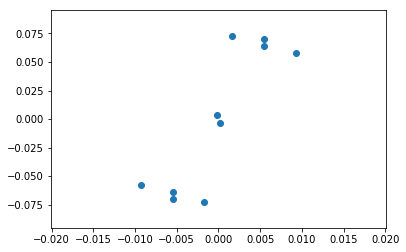

In [17]:
plt.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel())

Run Spearman

In [18]:
def pairwise_correlation(microbes_df, metabolites_df, func):
    n, d1 = microbes_df.shape
    n, d2 = metabolites_df.shape

    pearson_res = np.zeros((d1, d2))
    for i in range(d1):
        for j in range(d2):
            res = func(microbes_df.iloc[:, i],
                       metabolites_df.iloc[:, j])
            pearson_res[i, j] = res[0]
    ranks = pd.DataFrame(
        pearson_res,
        index=microbes_df.columns,
        columns=metabolites_df.columns)
    return ranks

In [19]:
abs_ranks = pairwise_correlation(abs_microbes, abs_metabolites, spearmanr)
abs_ranks

,P,I,SA,SG,F
theta_f,0.150057,0.116891,-0.160806,-0.107437,0.181044
theta_p,0.856761,0.655635,-0.978763,-0.797637,0.965418


In [20]:
rel_ranks = pairwise_correlation(rel_microbes, rel_metabolites, spearmanr)
rel_ranks

,P,I,SA,SG,F
theta_f,-0.373823,0.123108,0.685815,0.688999,-0.699784
theta_p,0.373823,-0.123108,-0.685815,-0.688999,0.699784


In [21]:
abs_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,4.0,3.0,1.0,2.0,5.0
theta_p,4.0,3.0,1.0,2.0,5.0


In [22]:
rel_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,2.0,3.0,4.0,5.0,1.0
theta_p,4.0,3.0,2.0,1.0,5.0


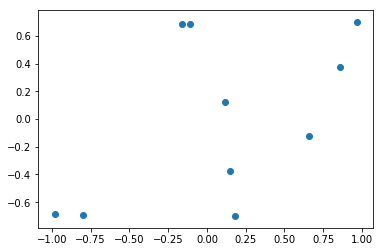

In [23]:
plt.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel())

Run Pearson 

In [24]:
abs_ranks = pairwise_correlation(abs_microbes, abs_metabolites, pearsonr)
abs_ranks

,P,I,SA,SG,F
theta_f,0.103066,0.094236,-0.081087,-0.065650,0.140610
theta_p,0.961746,0.884923,-0.977527,-0.790772,0.934611


In [25]:
rel_ranks = pairwise_correlation(rel_microbes, rel_metabolites, pearsonr)
rel_ranks

,P,I,SA,SG,F
theta_f,-0.852996,-0.526443,0.936625,0.942395,-0.831307
theta_p,0.852996,0.526443,-0.936625,-0.942395,0.831307


In [26]:
abs_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,4.0,3.0,1.0,2.0,5.0
theta_p,5.0,3.0,1.0,2.0,4.0


In [27]:
rel_ranks.apply(rankdata, axis=1)

,P,I,SA,SG,F
theta_f,1.0,3.0,4.0,5.0,2.0
theta_p,5.0,3.0,2.0,1.0,4.0


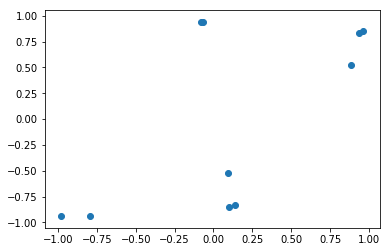

In [28]:
plt.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel())

One thing to note only the multimodal autoencoder has the same sign
The others have completely different sign.